# Vector data: Geopandas

[Geopandas](https://geopandas.org/en/stable/) is the primary package we use for geographic vector data. It extends the data types used by `pandas` to allow spatial operations on geometric types (performed by the `shapely` package internally).

We use one of the [administrative boundaries files](https://www.data.gv.at/katalog/dataset/verwaltungsgrenzen-vgd-stichtagsdaten-tirol#resources) (provided by the office of the government of Land Tirol in Austria under [CC BY 4.0 Deed license](https://creativecommons.org/licenses/by/4.0/)), more specifically we download [this file](https://nextcloud.bev.gv.at/nextcloud/index.php/s/iwTaNqjLcDqgf44) and unzip it into a sub-directory "tirol" within our data directory.

We use the pathlib package to set the path to our data directory (where we store sample data) as a variable `data_dir`.

In [2]:
from pathlib import Path
data_dir = Path(f'F:/OneDrive - uibk.ac.at/FE_WS2324/data')

## Reading vector data

Let's read one of the three Shapefiles contained in the directory into a `geopandas.GeoDataFrame`. Almost any vector-based spatial data format containing both geometry and attribute data (such as GeoJSON or Geopackage) is recognizesd by `geopandas.read_file()` and would work in the same way.

In [3]:
import geopandas as gpd
tirol = gpd.read_file(data_dir / "tirol" / "Tirol_BEV_VGD_250_LAM.shp")

Let's see how the first two features (lines in the table) of the `tirol` GeoDataFrame look like.

In [4]:
tirol.head(2)

,ST_KZ,FL,MERIDIAN,GKZ,BKZ,FA_NR,BL_KZ,KG_NR,KG,PG,PB,FA,GB_KZ,GB,VA_NR,VA,BL,ST,geometry
0,1,36336202,31,70733,707,82,7,85213,Untertilliach,Untertilliach,Lienz,Kitzbühel Lienz,850,Lienz,85,Lienz,Tirol,Österreich,"POLYGON ((351284.617 315719.819, 351918.758 31..."
1,1,9147234,31,70713,707,82,7,85204,Hollbruck,Kartitsch,Lienz,Kitzbühel Lienz,850,Lienz,85,Lienz,Tirol,Österreich,"POLYGON ((333260.458 316083.047, 333446.094 31..."


## Simple maps

In the table we have a number of attributes (with many of the abbreviated attribute names being difficult to interpret) and, importantly, we have a geometry column on the very right end of the table. Let's plot these geometries in a map and colorize the polygons by the "PB" attribute (the B stands probably for "Bezirk", which is a regional-level Austrian administrative unit (~district)).

<Axes: >

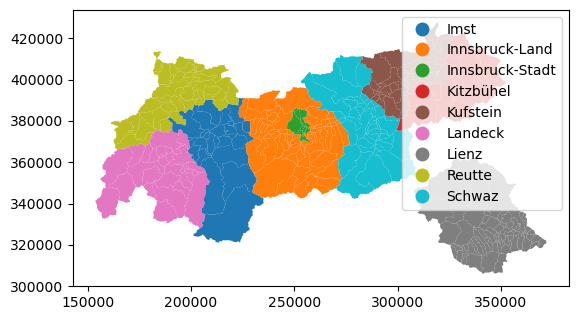

In [5]:
tirol.plot("PB", legend=True)

This simple plot allows us to quickly inspect the data and there are possibilities to improve it using `matplotlib` and other plotting packages. It shows coordinates as axis labels, but what is the coordinate reference system (CRS)?

In [6]:
print(tirol.crs)
print("\n More detailed information on the CRS: \n")
tirol.crs

EPSG:31287

 More detailed information on the CRS: 



<Projected CRS: EPSG:31287>
Name: MGI / Austria Lambert
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Austria.
- bounds: (9.53, 46.4, 17.17, 49.02)
Coordinate Operation:
- name: Austria Lambert
- method: Lambert Conic Conformal (2SP)
Datum: Militar-Geographische Institut
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

## Geometric operations on vector data

We can also use geopandas to compute the area of the polygons and store it in a new attibute column called "area".

In [7]:
tirol["area"] = tirol.area/1000000  # Map units are metres (as shown in the CRS metadata), convert area from m² to km²

Text(0.5, 1.0, 'Area of municipalities of Tirol [km²]')

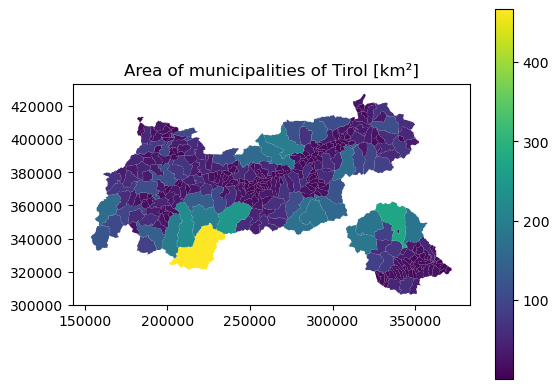

In [8]:
from matplotlib import pyplot as plt
tirol.plot("area", legend=True)
plt.title('Area of municipalities of Tirol [km²]')

## Subsets

For a new GeoDataFrame called "ibk", let's select a subset of the "tirol" GeoDataFrame containing only the municipal area of the city of Innsbruck. We do this by a conditional expression on the municipality column (which is called "PG"). If you want to make a subset already during import of a vector dataset, look up the selection methods [here](https://geopandas.org/en/stable/docs/user_guide/io.html#reading-subsets-of-the-data).

In [9]:
ibk = tirol[tirol["PG"] == "Innsbruck"]

## Interactive maps

To have get a better view of the data, including a web-based background layer and the possibilit to zoom and pan, we use Geopandas' built-in method `GeoDataFrame.explore()` to create an interactive Leaflet map. This works via the [Folium](https://python-visualization.github.io/folium/latest/) library internally, which has a number of built-in tilesets from OpenStreetMap, Mapbox, etc, and supports custom tilesets. Vector attributes are shown on mouse-over. Later in the course we will customize such maps a bit.

In [10]:
ibk.explore()

## Re-projection

Our data is in a national CRS, which is often incompatible with the rest of our data (acquired from global scale satellite data archives or by GNSS measurements in the field, for instance) which is typically in a different CRS. But don't worry, we can easily [re-project](https://geopandas.org/en/stable/getting_started/introduction.html#Projections) the geometries of our data to another CRS, thus making it compatible for joint visualization and analysis with other data such as satellite imagery. The easiest way to define a CRS is via an EPSG code (which can be looked up at https://epsg.io/).

In [11]:
print(ibk.crs)      # Show only the EPSG code
ibk_utm = ibk.to_crs("EPSG:32632")  # Re-project to EPSG:32632
ibk_utm.crs         # Show CRS information after re-projection

EPSG:31287


<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Writing vector data

To write a GeoDataFrame back to file use `GeoDataFrame.to_file()`. The default file format is Shapefile, but you can specify your own with the driver keyword.

In [12]:
ibk_utm.to_file(data_dir / "tirol" / "innsbruck.gpkg", driver='GPKG')

## Dissolve polygons

If we want to do an analysis at a coarser level, e.g., for districts, the municipality polygons can be dissolved by the district column ('PB') and geopandas can, e.g., sum up the area of all municipalities in a district (more aggregation options are available, such as mean, minimum or maximum, ...; see the [documentation](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html)).

In [19]:
# Dissolve by districts ('PB' attribute) and sum up the area of their municipalities
districts = tirol.dissolve(by='PB', aggfunc={'area': 'sum'})
districts   # Show the GeoDataFrame

,geometry,area
PB,,
Imst,"POLYGON ((206586.407 334773.410, 206168.211 33...",1723.983146
Innsbruck-Land,"POLYGON ((240943.882 343263.997, 240591.673 34...",1989.285665
Innsbruck-Stadt,"POLYGON ((255095.061 372623.401, 255169.732 37...",104.712177
Kitzbühel,"POLYGON ((315095.968 396867.394, 315132.915 39...",1161.741353
Kufstein,"POLYGON ((299074.104 381374.166, 298682.327 38...",969.229330
Landeck,"POLYGON ((193058.209 332835.454, 192867.887 33...",1594.594778
Lienz,"POLYGON ((339653.906 307289.062, 339367.216 30...",2019.128342
Reutte,"MULTIPOLYGON (((181326.148 373897.774, 180786....",1235.533926
Schwaz,"POLYGON ((288645.345 346813.812, 288430.744 34...",1841.607396


## Customize maps

Plot the district polygons and customize the map a bit (scalebar, colormap, ...), now using `matplotlib`'s object-oriented interface where the plot of the districts is an axes object. Adding a scalebar is easy with the [matplotlib-scalebar](https://github.com/ppinard/matplotlib-scalebar) package, if we are using a projected coordinate system with meters as units: Just set `dx = 1`. With the `contextily` pacakge we can add a basemap from an xyz tiles provider to the axes object.

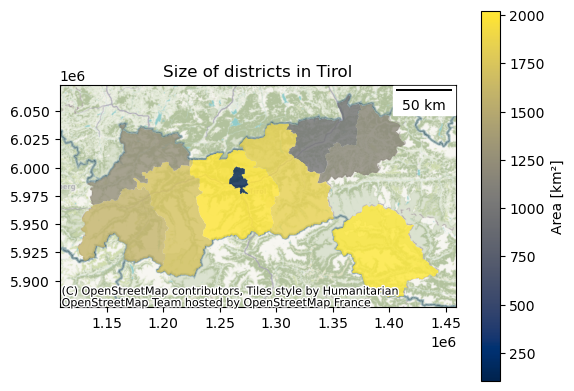

In [20]:
from matplotlib import pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar   # Needs to be installed (mamba install matplotlib-scalebar)

districts_wm = districts.to_crs(epsg=3857)          # Convert the CRS of our data to match the CRS used typically by web map tiles (Web Mercator)
ax = districts_wm.plot(
    column='area',                          # Colorize the polygons by values in this column
    cmap='cividis',                         # Select a colourmap
    legend_kwds={'label': 'Area [km²]'},
    legend=True,
    alpha=0.8);
ax.set_title('Size of districts in Tirol')
cx.add_basemap(ax)                          # Add a basemap from an xyz tiles provider (default is OSM)
ax.add_artist(ScaleBar(dx=1))               # Add a scalebar

## More vector data processing

Much more can be done with GeoPandas, such as [spatial joins](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html), [buffers](https://geopandas.org/en/stable/getting_started/introduction.html#Buffer) and [spatial intersections](https://geopandas.org/en/stable/getting_started/introduction.html#Geometry-relations).